In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import argparse
import utils
import matplotlib.pyplot as plt
from models.vqvae import VQVAE
import torchvision.transforms as transforms
parser = argparse.ArgumentParser()

"""
Hyperparameters
"""
timestamp = utils.readable_timestamp()

parser.add_argument("--batch_size", type=int, default=32)
parser.add_argument("--n_updates", type=int, default=5000)
parser.add_argument("--n_hiddens", type=int, default=128)
parser.add_argument("--n_residual_hiddens", type=int, default=32)
parser.add_argument("--n_residual_layers", type=int, default=2)
parser.add_argument("--embedding_dim", type=int, default=64)
parser.add_argument("--n_embeddings", type=int, default=512)
parser.add_argument("--beta", type=float, default=.25)
parser.add_argument("--learning_rate", type=float, default=3e-4)
parser.add_argument("--log_interval", type=int, default=50)
parser.add_argument("--dataset",  type=str, default='CIFAR10')

# whether or not to save model
parser.add_argument("-save", action="store_true")
parser.add_argument("--filename",  type=str, default=timestamp)

args = parser.parse_args(args=["-save", "--log_interval=5000","--n_updates=%d"%(500000), "--filename=imagenet"+timestamp,"--dataset=imagenet"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if args.save:
    print('Results will be saved in ./results/vqvae_' + args.filename + '.pth')
    !mkdir results -p

/home/chenningcong/Desktop/Deeplearning/deep/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Results will be saved in ./results/vqvae_imagenetmon_mar_4_14_25_32_2024.pth


In [2]:
import importlib 
import utils
importlib.reload(utils)

<module 'utils' from '/home/chenningcong/Desktop/Deeplearning/autoencoder/vqvae/utils.py'>

In [3]:
class InGPUDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.data = (torch.stack([i[0] for i in dataset]).to(device), torch.tensor([i[1] for i in dataset]).to(device))
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, i):
        return self.data[0][i], self.data[1][i]
class ImageNet(torch.utils.data.Dataset):
    def __init__(self):
        self.images = torch.tensor(np.load("data/tiny-imagenet/image.npy")).to(device)
        with torch.no_grad():
            self.images = (2/255)*self.images.permute((0, 3,1,2)) - 1 
        torch.cuda.empty_cache()
        self.labels = torch.tensor(np.load("data/tiny-imagenet/label.npy")).to(device)
    def __len__(self):
        return self.images.shape[0]
    def __getitem__(self, i):
        return self.images[i], self.labels[i]
def load_data_and_data_loaders_cifar(dataset, batch_size):
    training_data, validation_data = utils.load_cifar()
    x_train_var = np.var(training_data.data)
    training_data = InGPUDataset(training_data)
    validation_data = InGPUDataset(validation_data)
    training_loader, validation_loader = utils.data_loaders(
        training_data, validation_data, batch_size)
    return training_data, validation_data, training_loader, validation_loader, x_train_var

In [4]:
torch.cuda.empty_cache()

In [5]:
full_dataset = ImageNet()

In [6]:
def load_data_and_data_loaders_imagenet(dataset, batch_size):
    train_size = int(0.95 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    training_data, validation_data = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    x_train_var = torch.var(full_dataset.images)
    training_data = InGPUDataset(training_data)
    validation_data = InGPUDataset(validation_data)
    training_loader, validation_loader = utils.data_loaders(
        training_data, validation_data, batch_size)
    return training_data, validation_data, training_loader, validation_loader, x_train_var

In [7]:
training_data, validation_data, training_loader, validation_loader, x_train_var = load_data_and_data_loaders_imagenet(
    args.dataset, args.batch_size)

In [8]:
from tqdm import tqdm
"""
Load data and define batch data loaders
"""

"""
Set up VQ-VAE model with components defined in ./models/ folder
"""

model = VQVAE(args.n_hiddens, args.n_residual_hiddens,
              args.n_residual_layers, args.n_embeddings, args.embedding_dim, args.beta).to(device)
!rm runs/* -rf

In [9]:
torch.cuda.empty_cache()

In [10]:
model

VQVAE(
  (encoder): Encoder(
    (conv_stack): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ResidualStack(
        (stack): ModuleList(
          (0-1): 2 x ResidualLayer(
            (res_block): Sequential(
              (0): ReLU(inplace=True)
              (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (2): ReLU(inplace=True)
              (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
          )
        )
      )
    )
  )
  (pre_quantization_conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (vector_quantization): VectorQuantizer(
    (embedding): Embedding(512, 64)
  )
  (decoder): Decoder(
    (inverse_conv_stack): Sequential(
      (0): Con

In [12]:
!mkdir plot -p
def show_image(n_iter, id = 8, clip=False):
    f, axarr = plt.subplots(2, id, figsize=(id*4, 8))
    model.eval()
    scale_img = lambda x : (x+1)/2
    for i in range(0, id):
        data = training_data[i][0]
        axarr[0][i].axis("off")
        axarr[0][i].imshow(scale_img(data.permute((1,2,0)).cpu().detach().numpy()))
        with torch.no_grad():
            _, output, _ = model(data.unsqueeze(0).to(device))
        if clip:
            output = torch.clip(output, min=-1,max=1)
        output = scale_img(output)
        output = output.squeeze(0).permute((1,2,0)).cpu().detach().numpy()
        axarr[1][i].axis("off")
        axarr[1][i].imshow(output)
    f.suptitle("Face plot"+str(n_iter))
    plt.savefig("plot/" + str(n_iter) + ".png")
    plt.show()


  0%|                                          | 0/500000 [00:00<?, ?it/s]

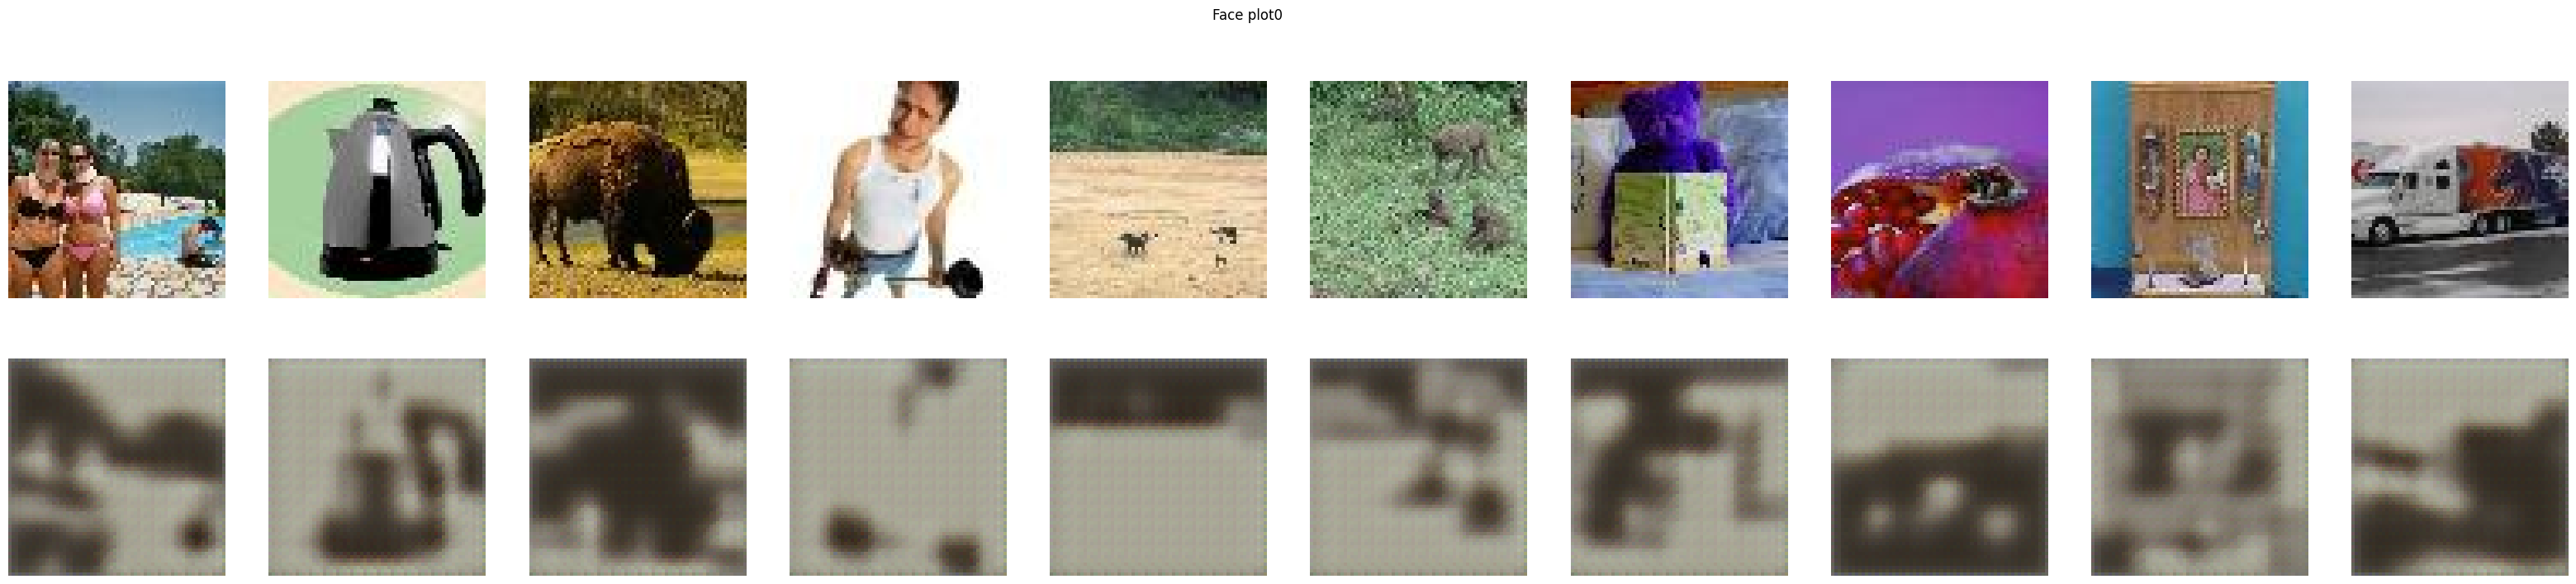

  1%|▏                 | 4994/500000 [00:44<1:10:36, 116.84it/s, saving=0]

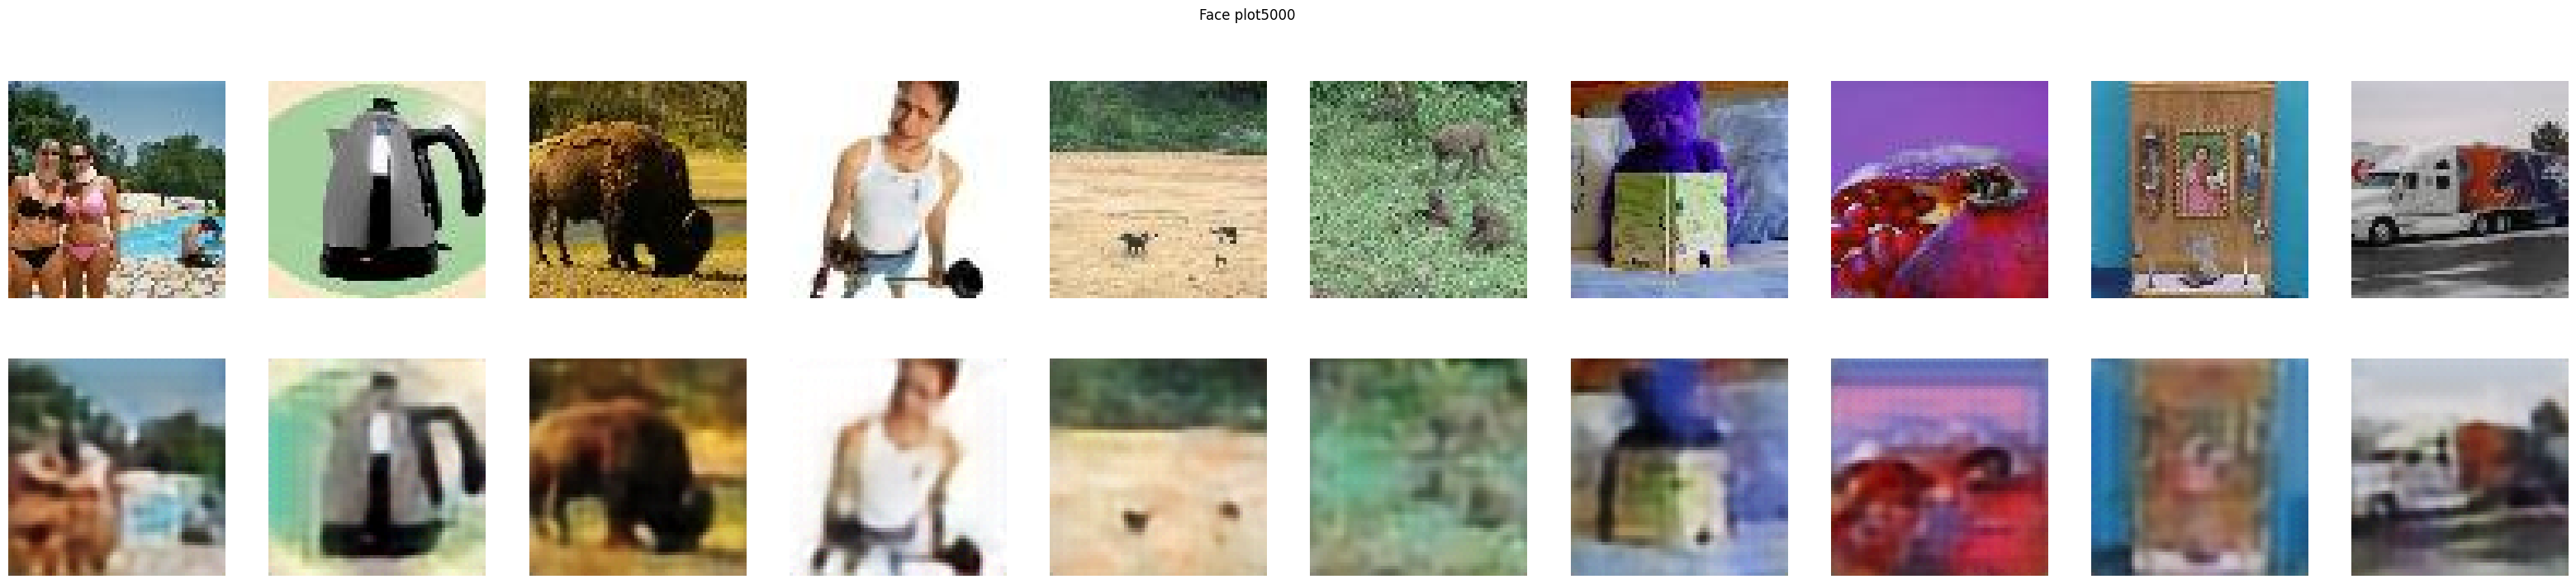

  2%|▎              | 9998/500000 [01:30<1:15:12, 108.58it/s, saving=5000]

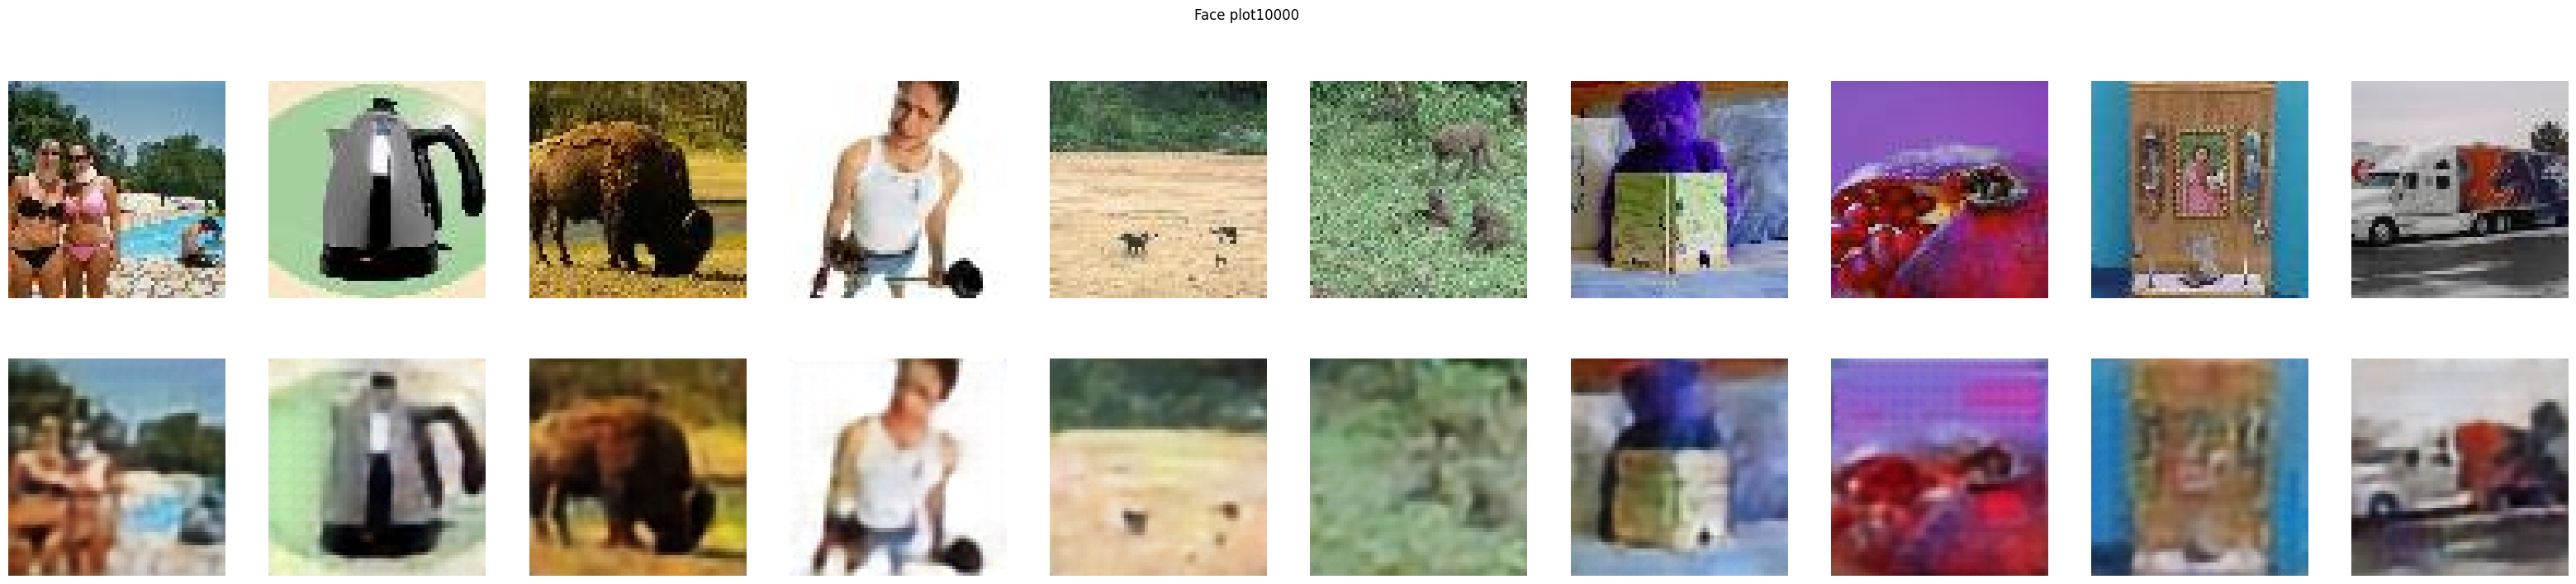

  3%|▍             | 14992/500000 [02:18<1:14:15, 108.86it/s, saving=1e+4]

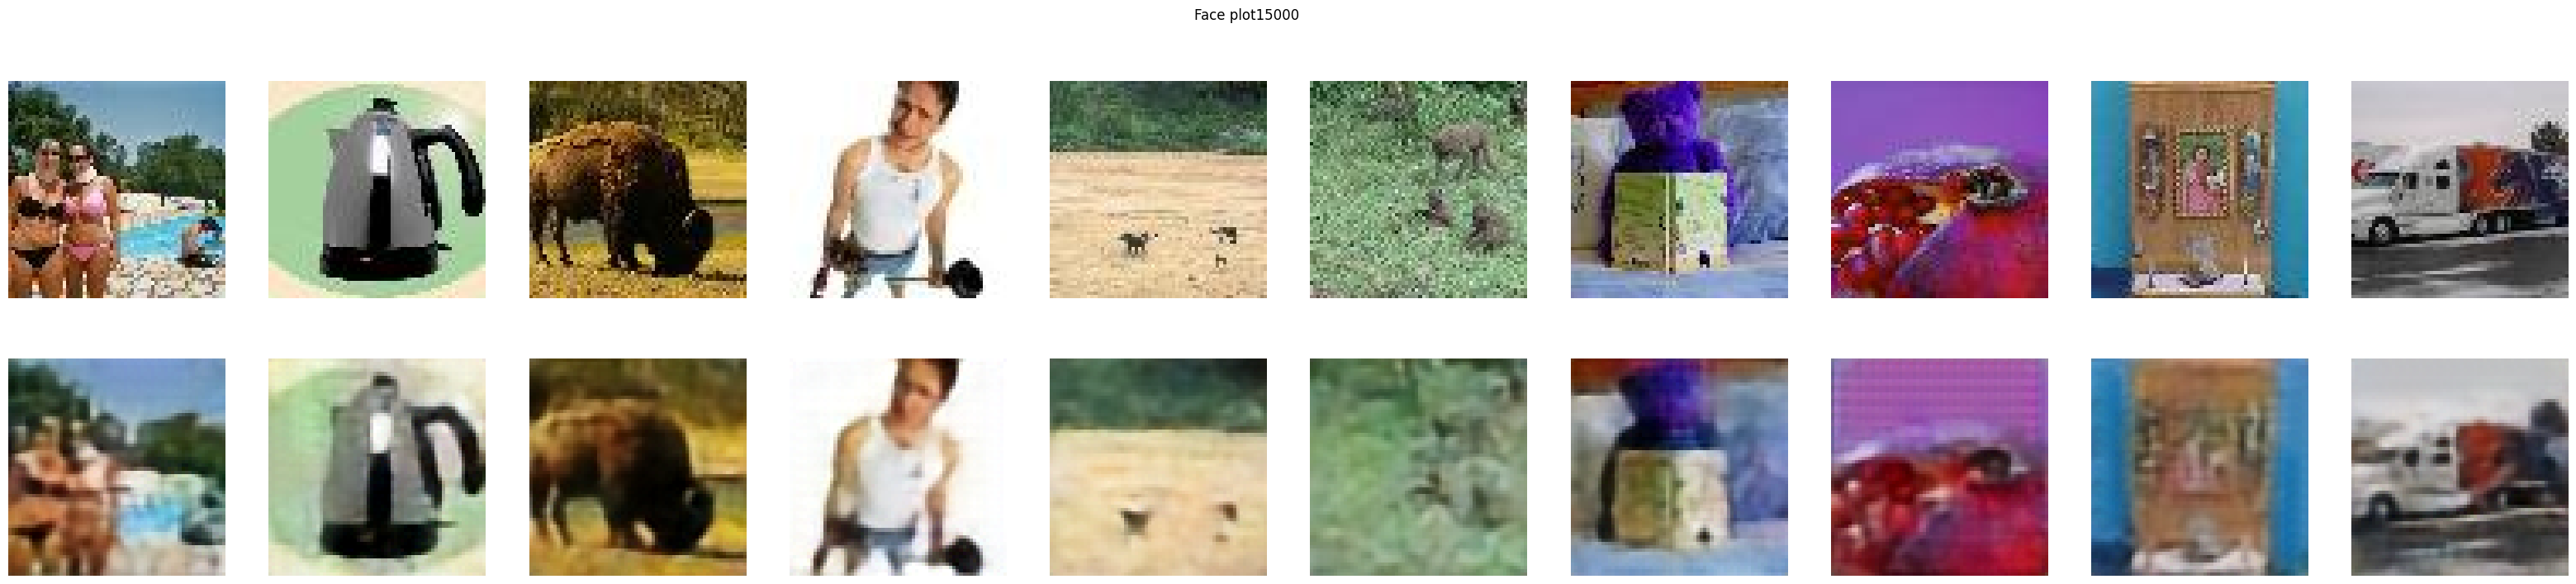

  4%|▌            | 19996/500000 [03:08<1:14:32, 107.32it/s, saving=15000]

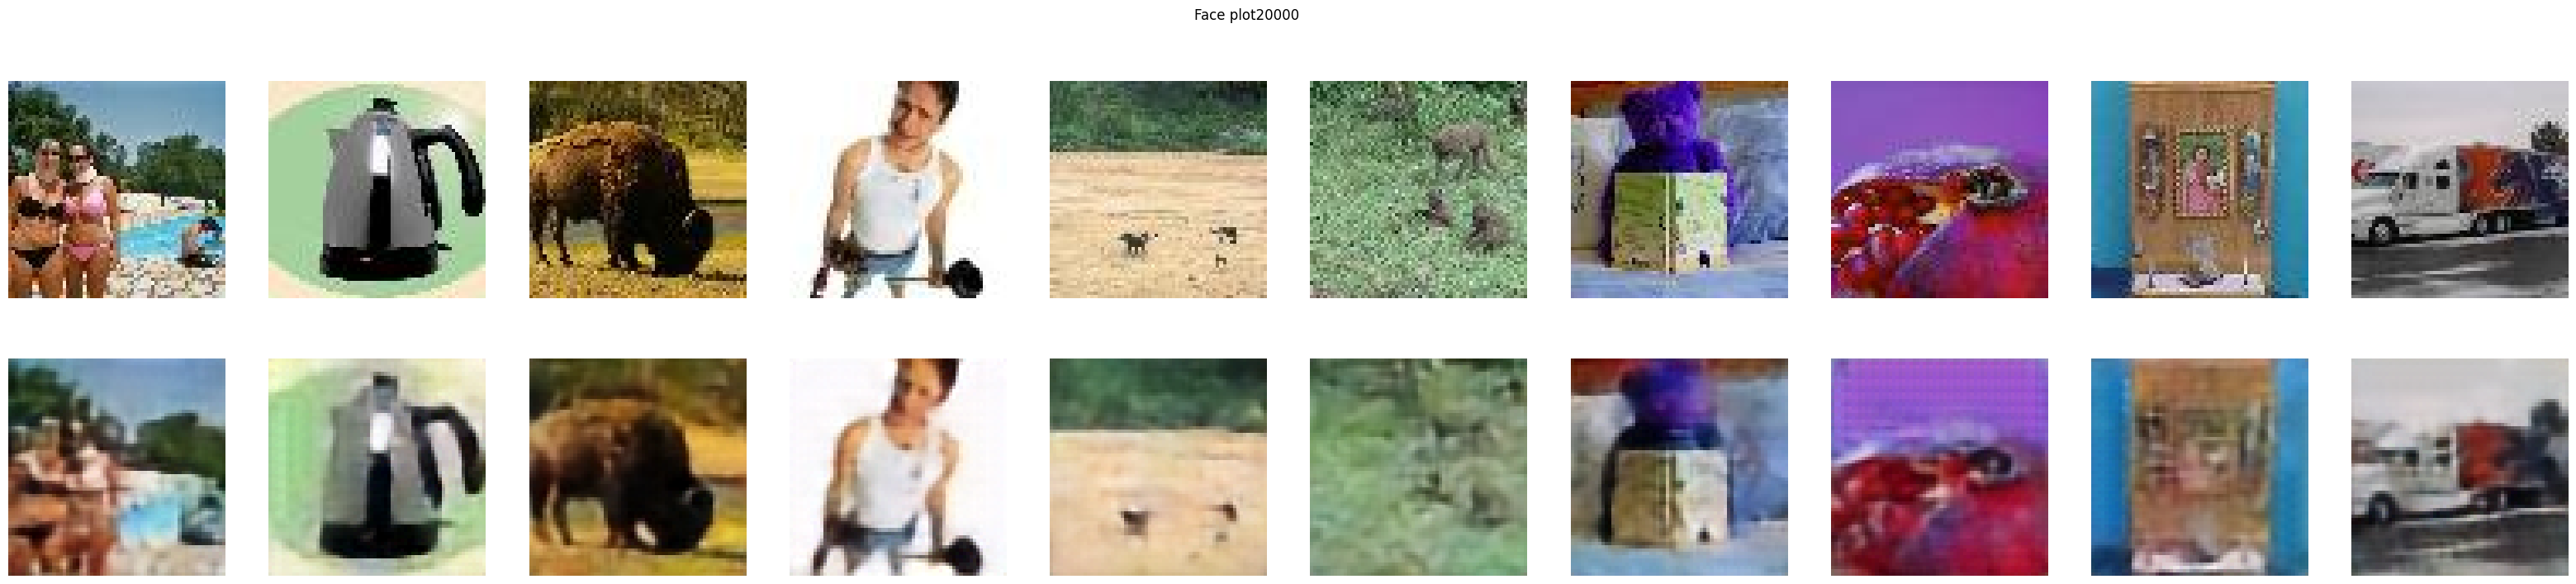

  5%|▋             | 24989/500000 [03:55<1:11:10, 111.22it/s, saving=2e+4]

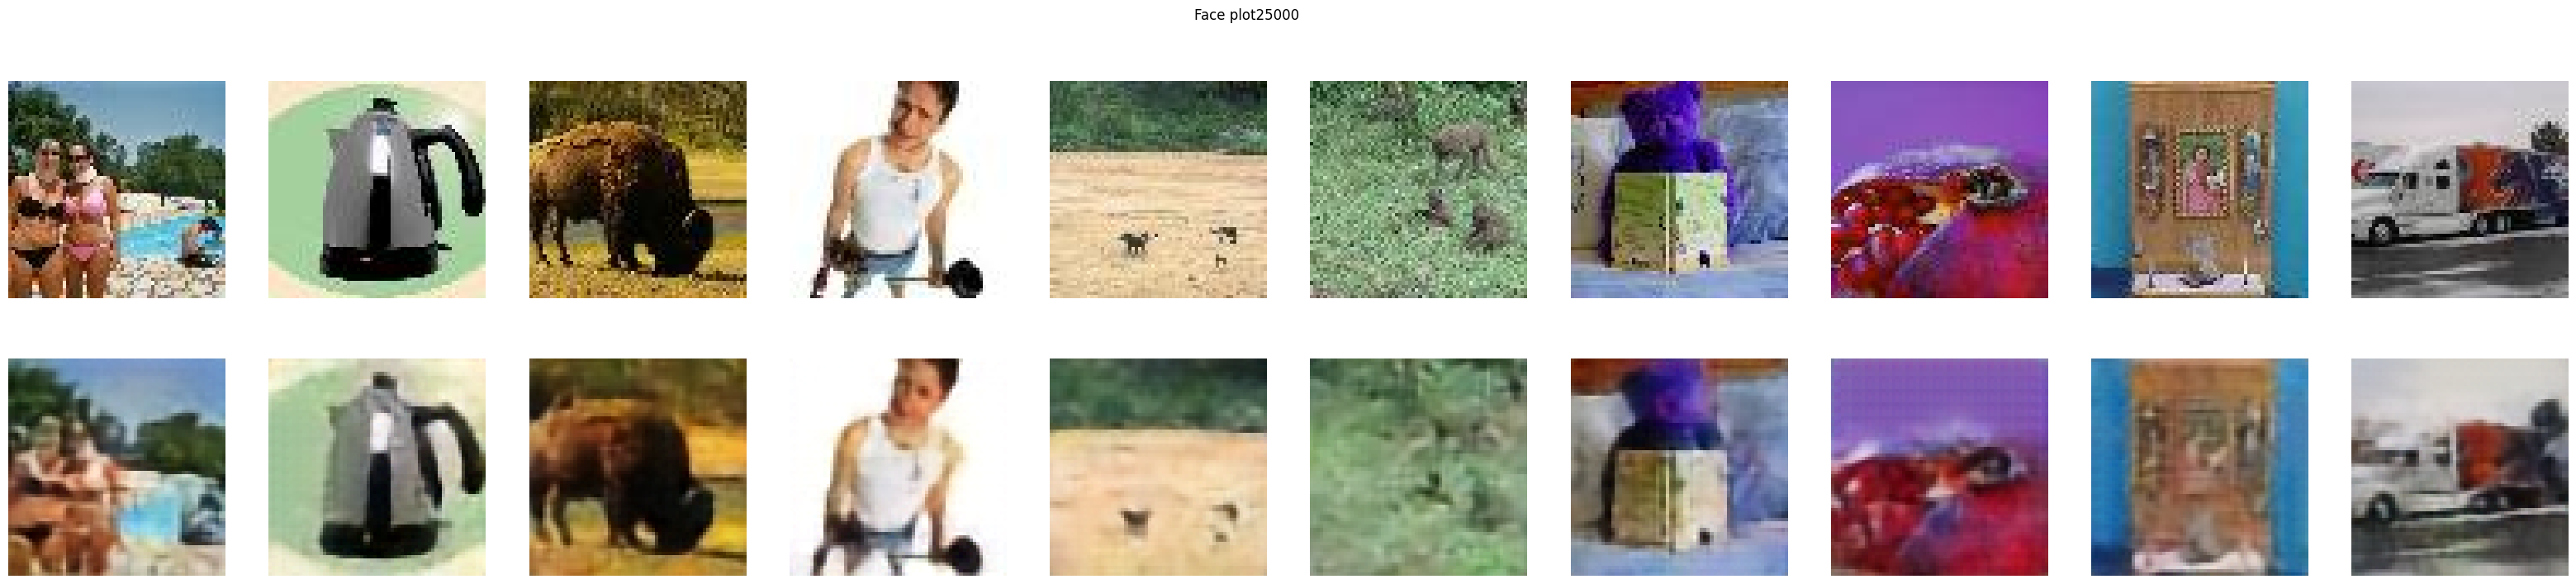

  6%|▊            | 30000/500000 [04:42<1:14:11, 105.59it/s, saving=25000]

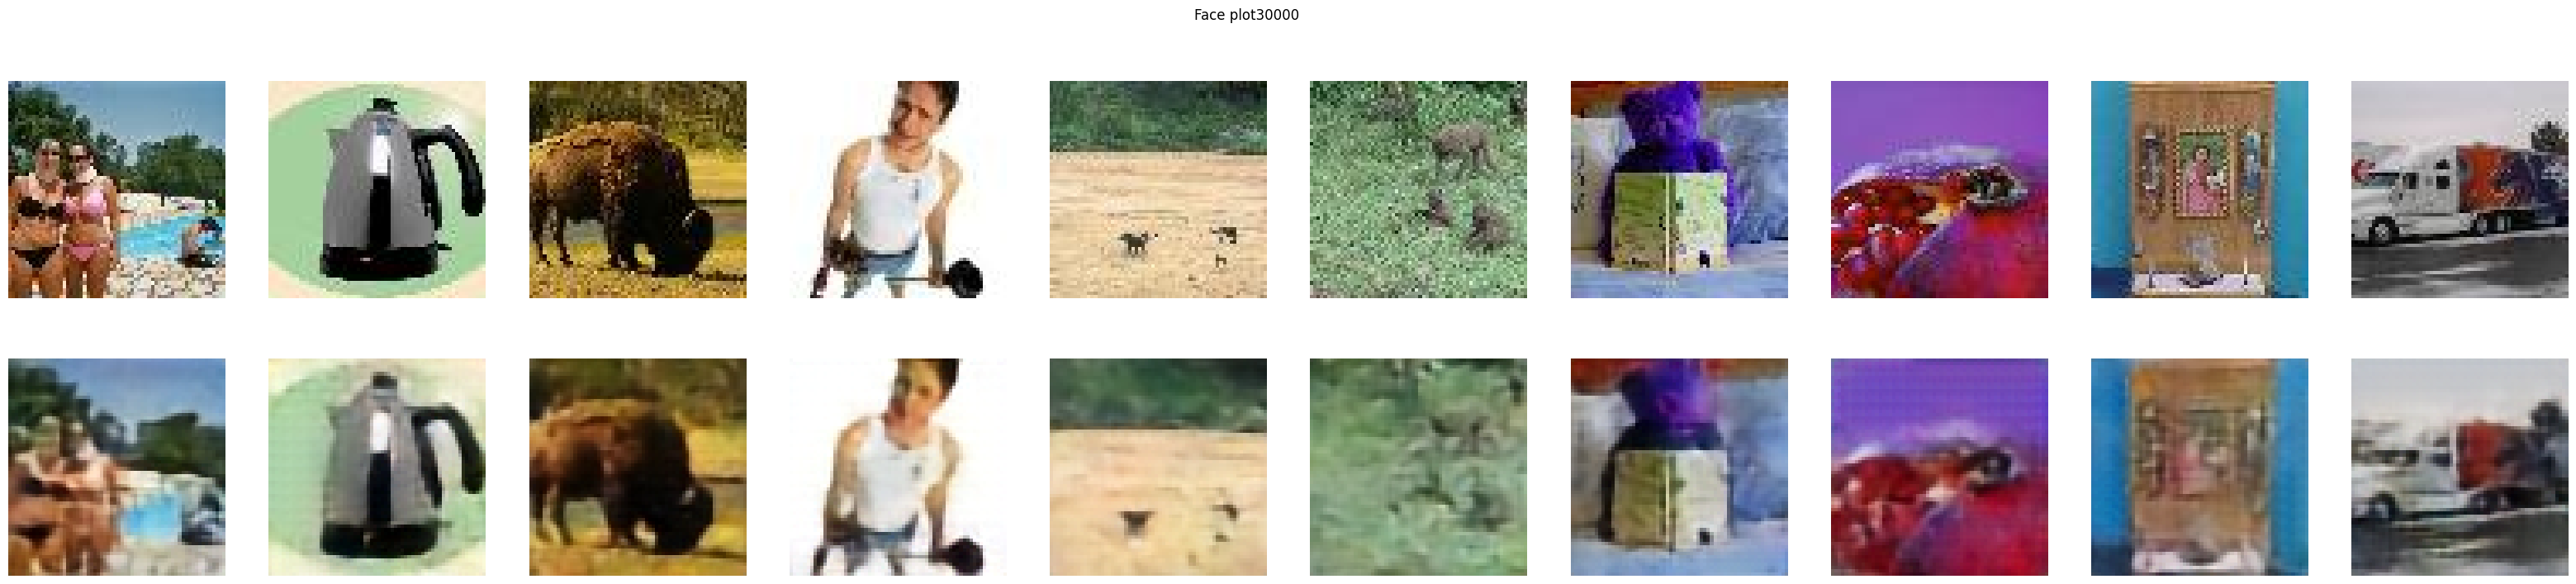

  7%|▉             | 34989/500000 [05:28<1:06:29, 116.57it/s, saving=3e+4]

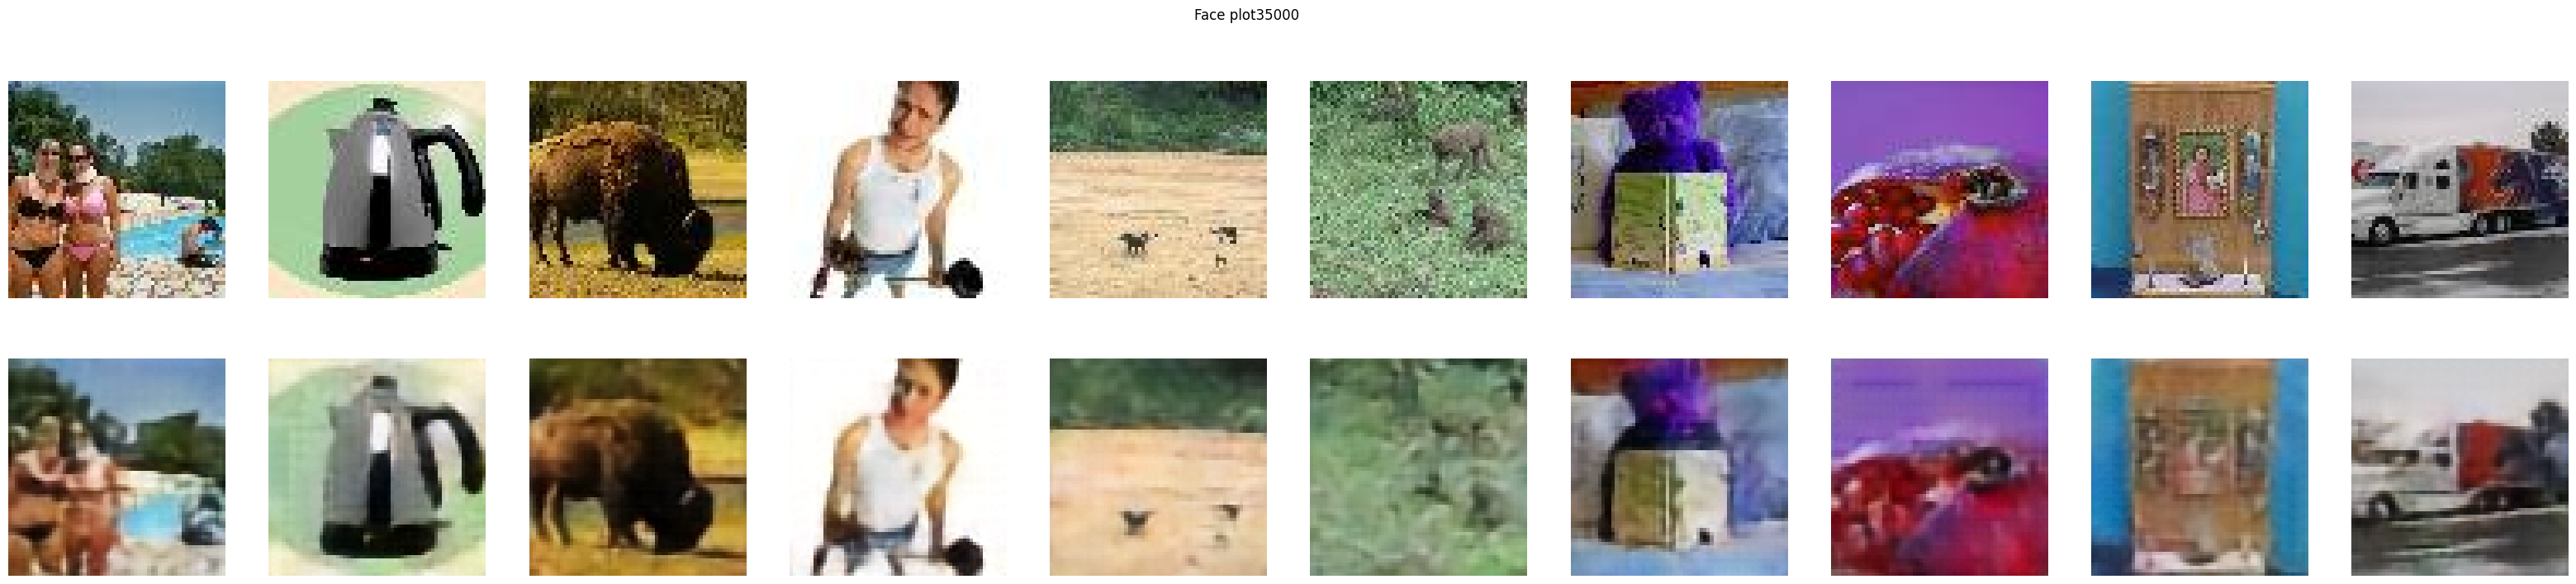

  8%|█            | 39993/500000 [06:13<1:04:49, 118.26it/s, saving=35000]

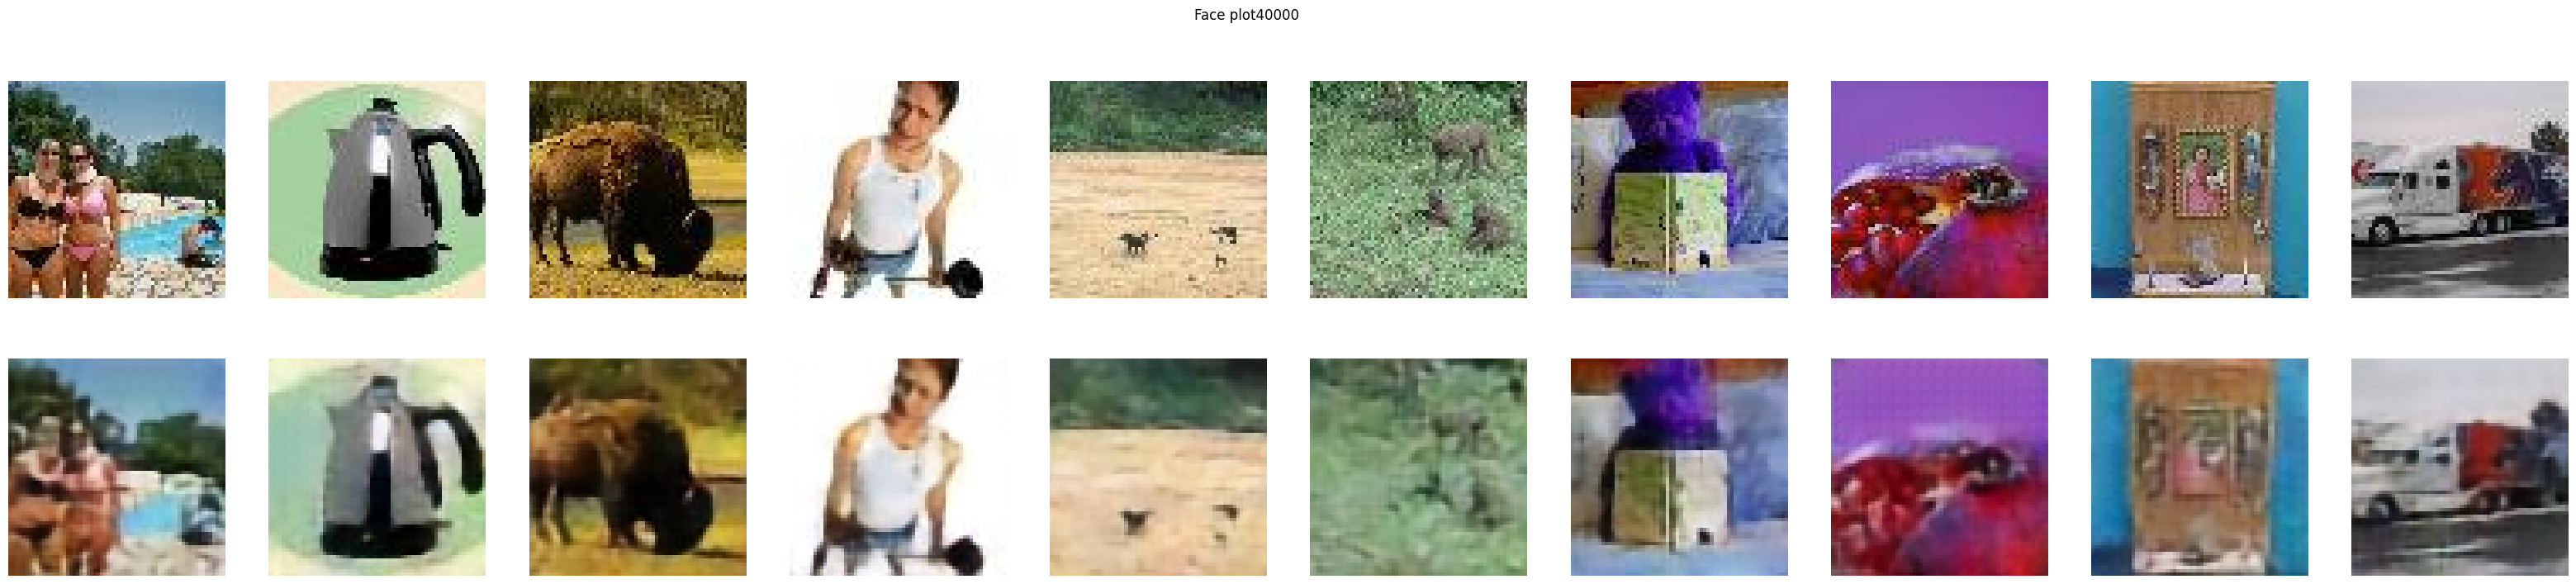

  9%|█▎            | 44997/500000 [07:00<1:14:16, 102.11it/s, saving=4e+4]

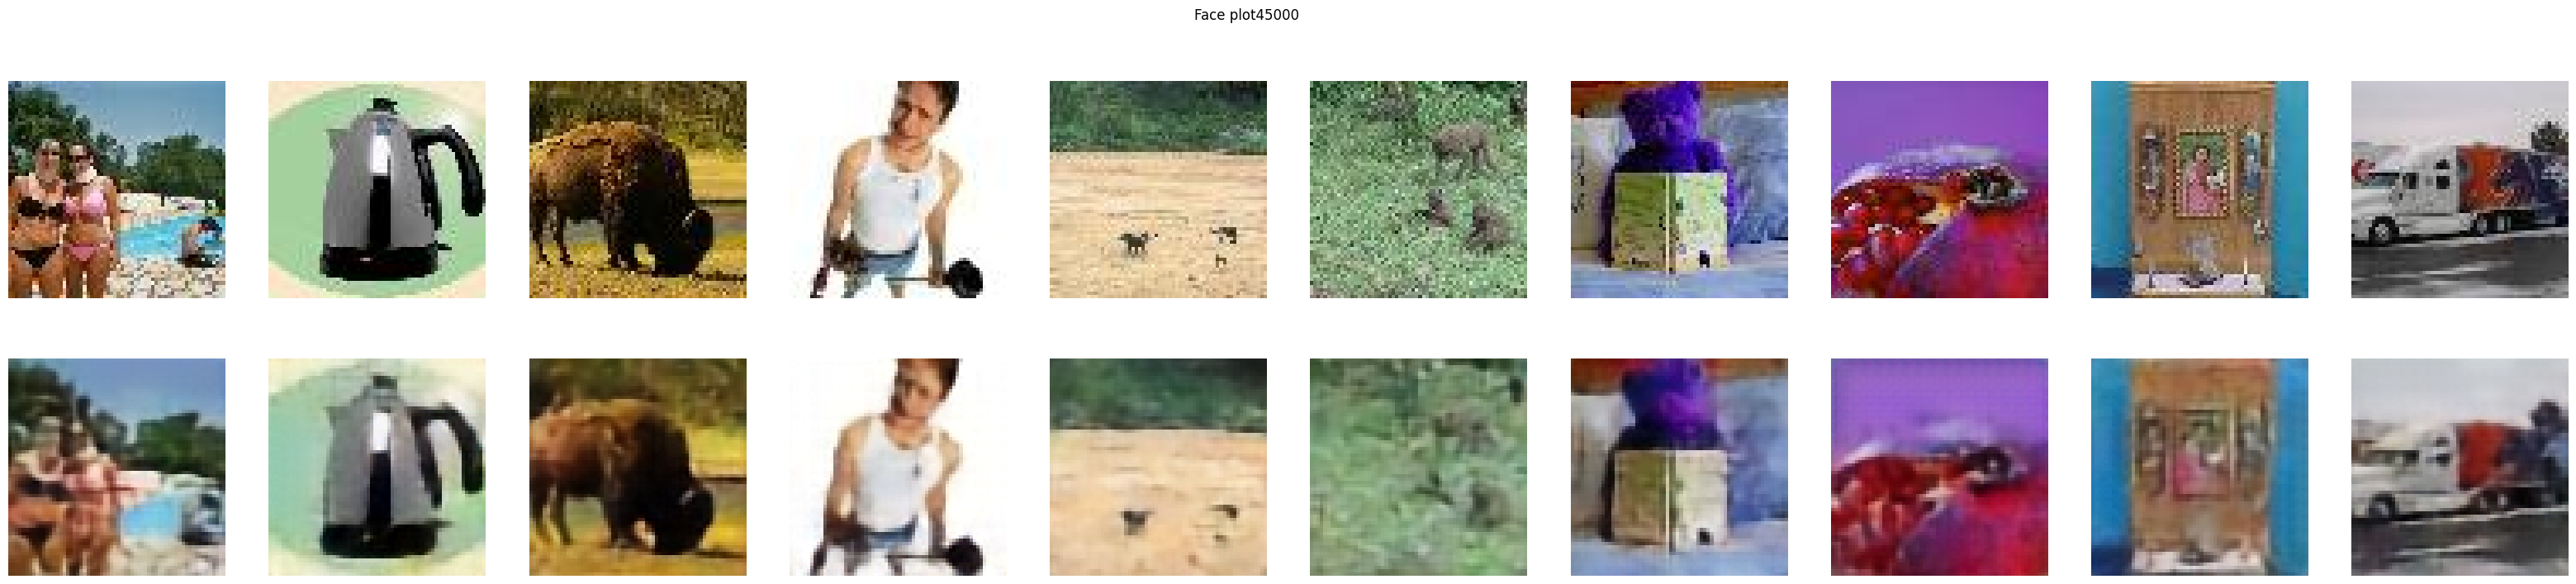

 10%|█▎           | 49993/500000 [07:45<1:03:26, 118.23it/s, saving=45000]

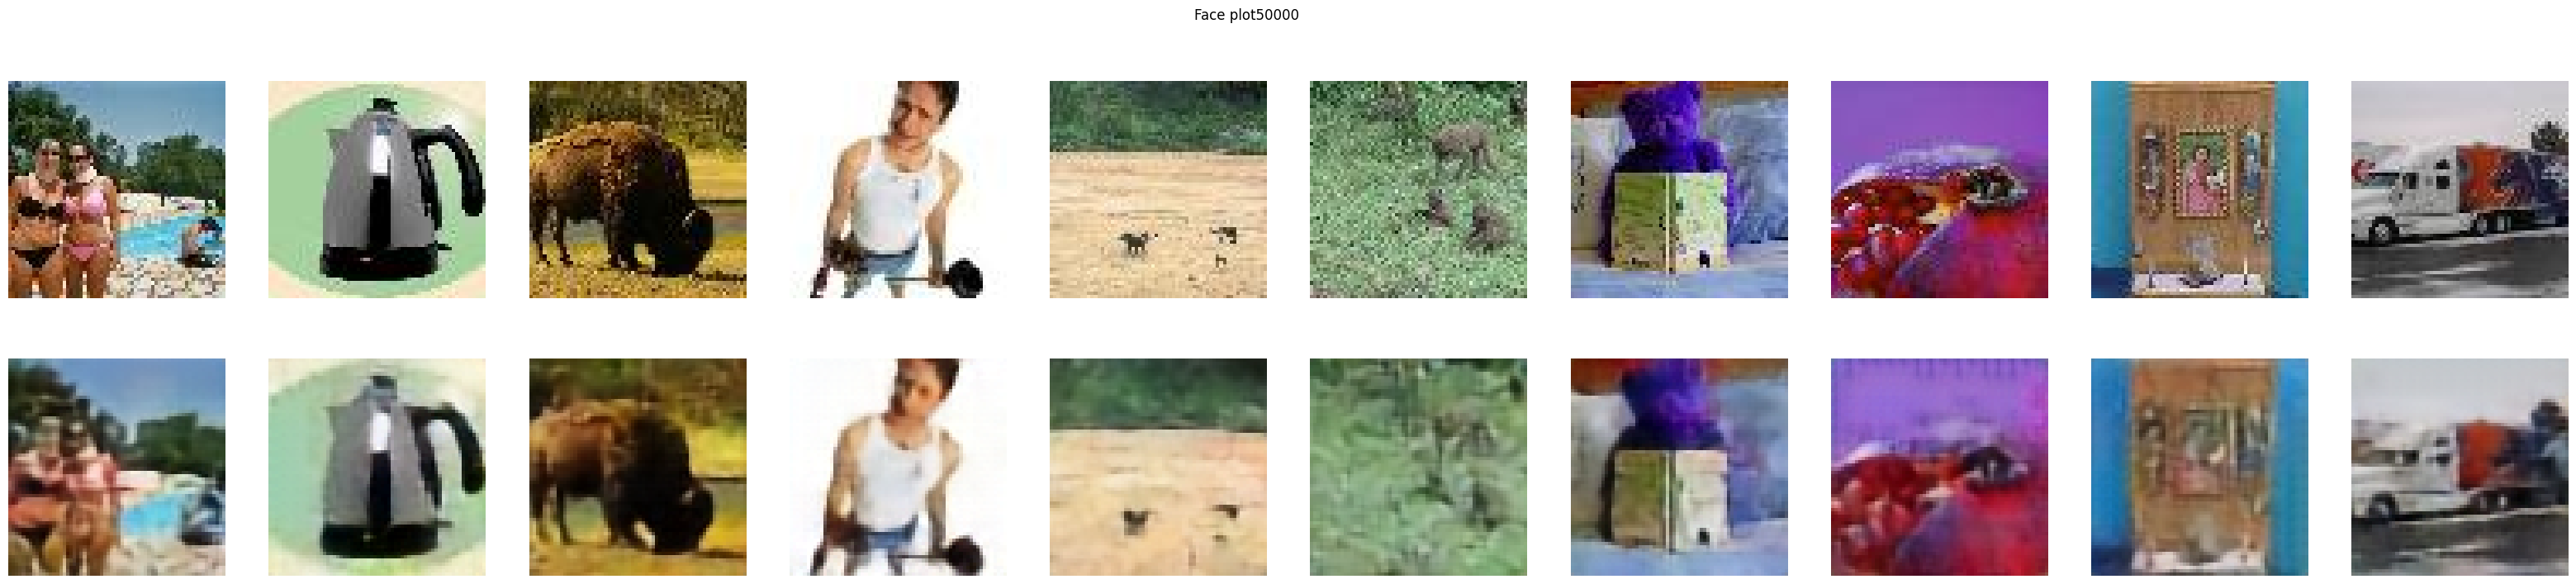

 11%|█▌            | 55000/500000 [08:31<1:06:31, 111.48it/s, saving=5e+4]

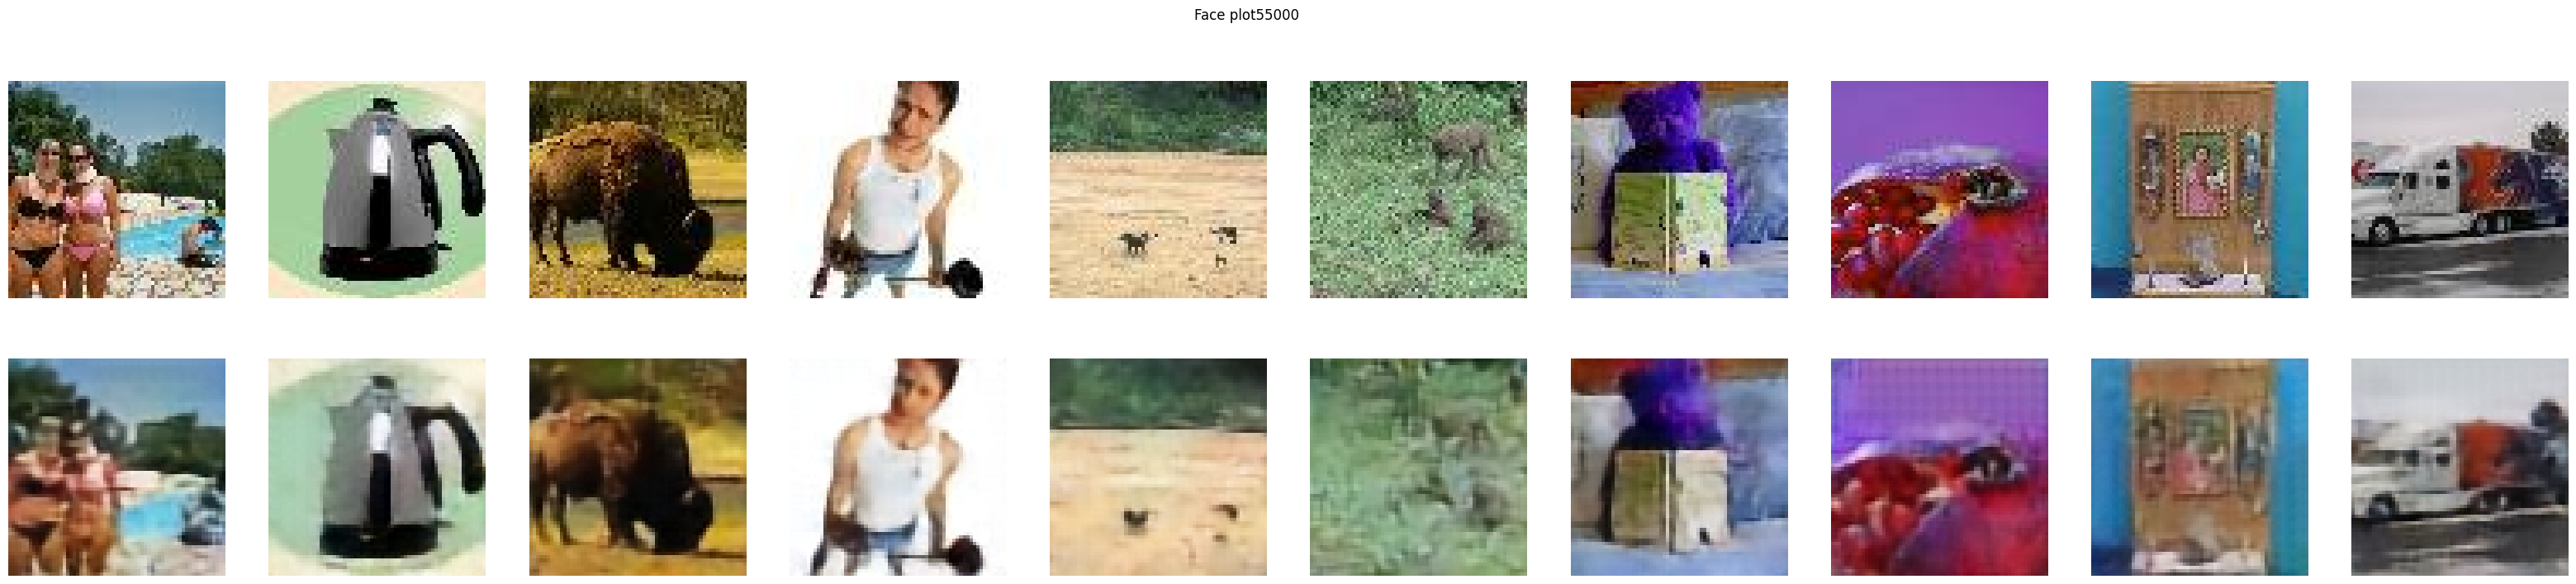

 12%|█▌           | 59996/500000 [09:15<1:03:32, 115.41it/s, saving=55000]

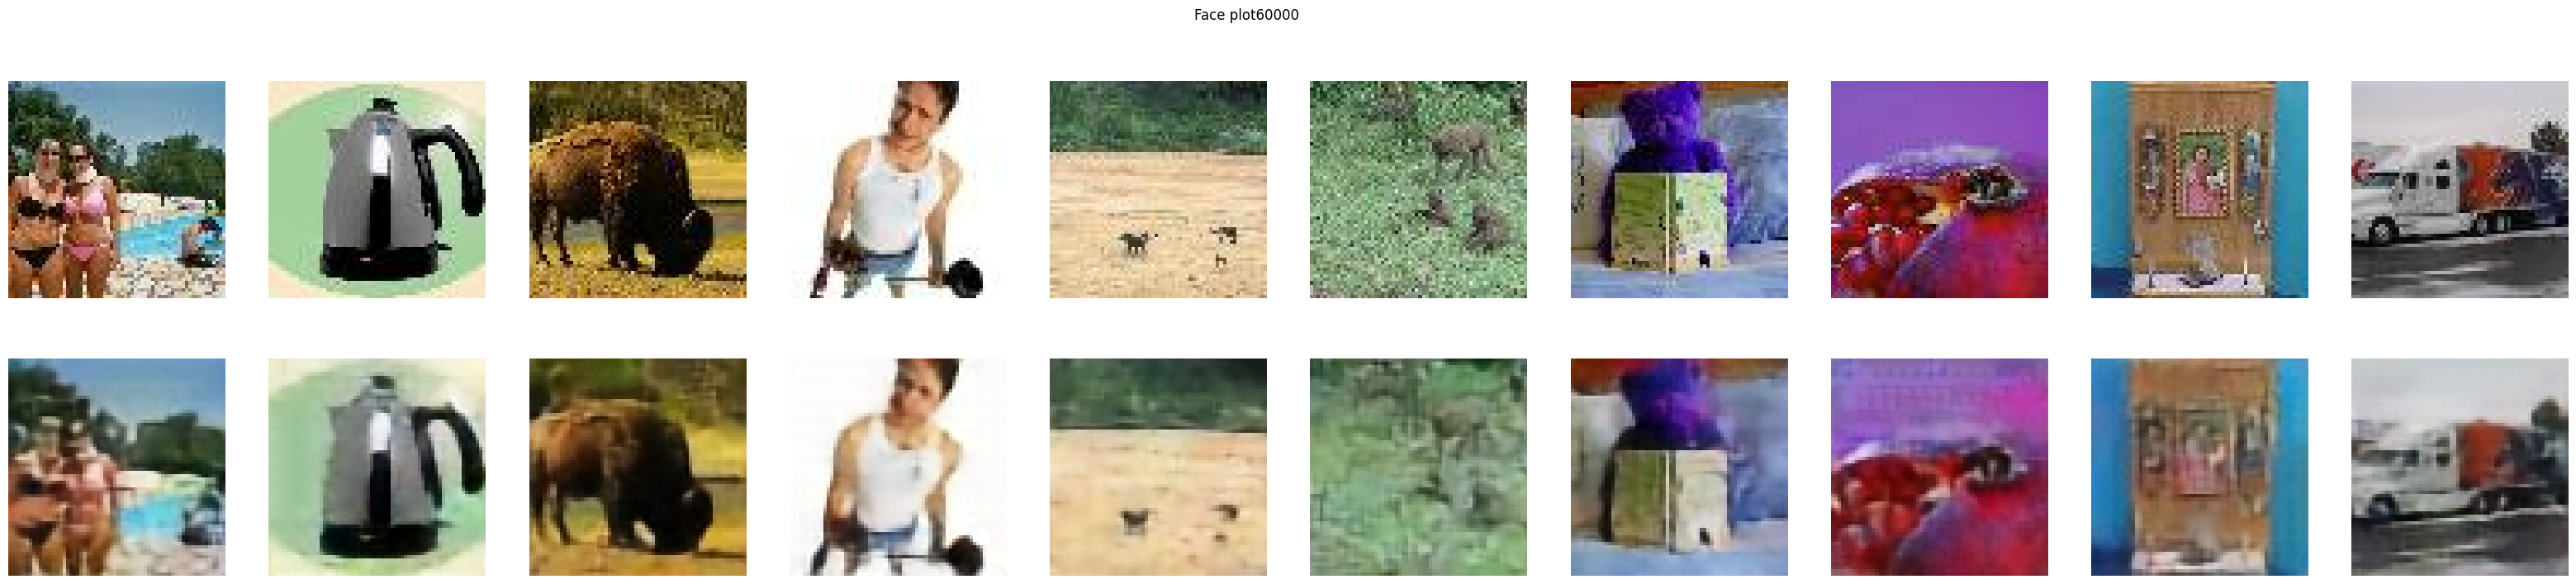

 13%|█▊            | 64993/500000 [10:01<1:06:45, 108.61it/s, saving=6e+4]

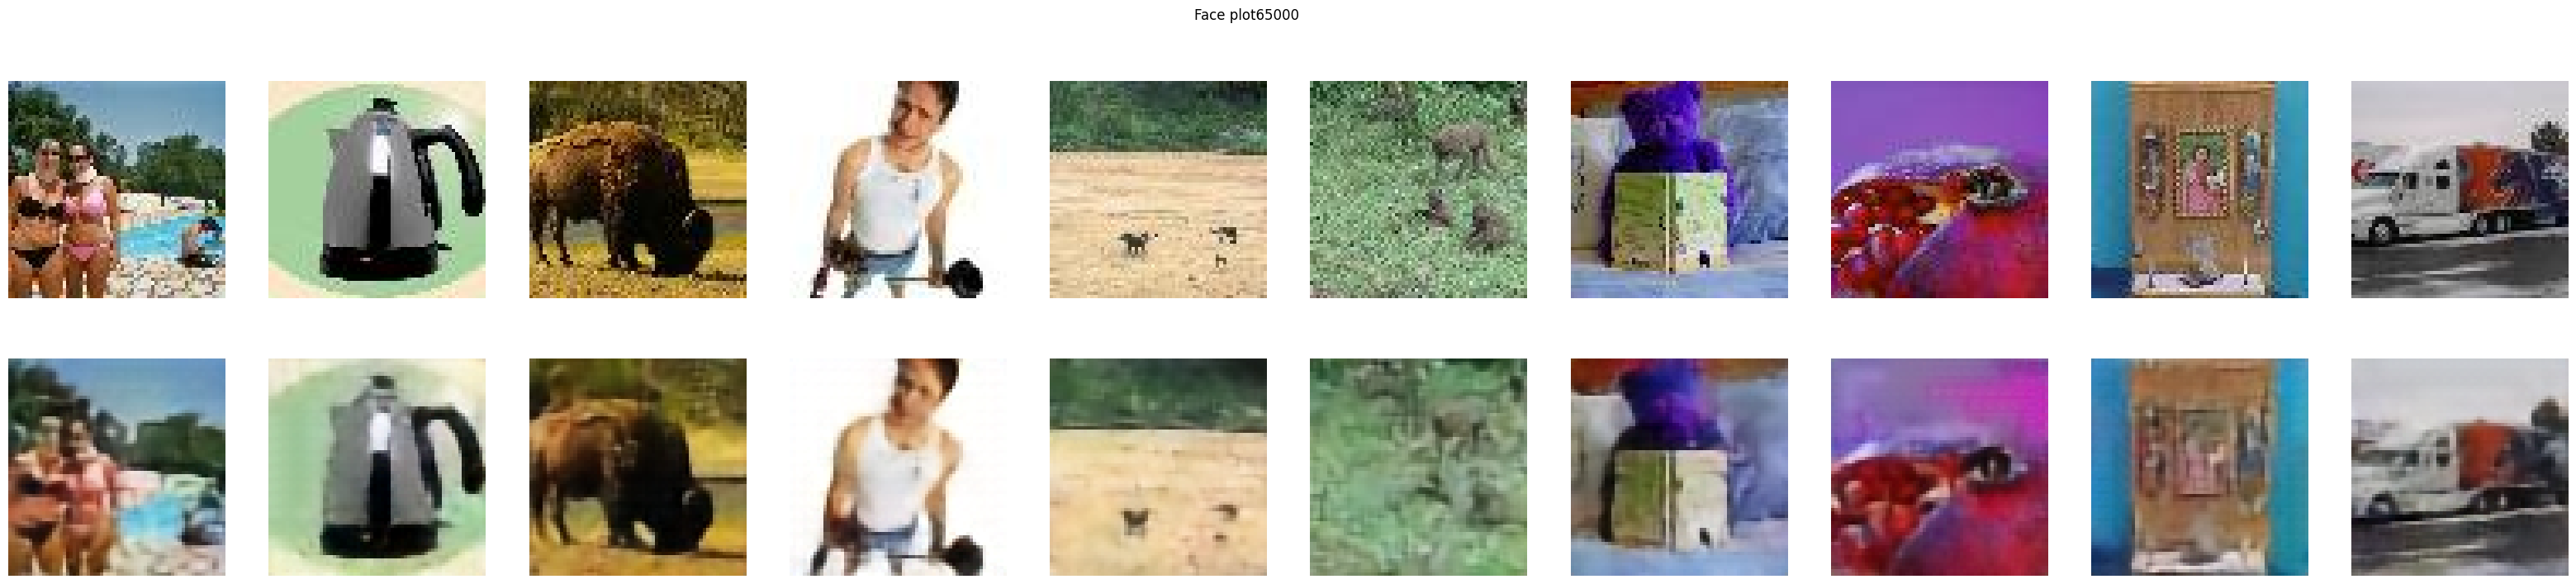

 14%|█▊           | 69996/500000 [10:46<1:00:55, 117.62it/s, saving=65000]

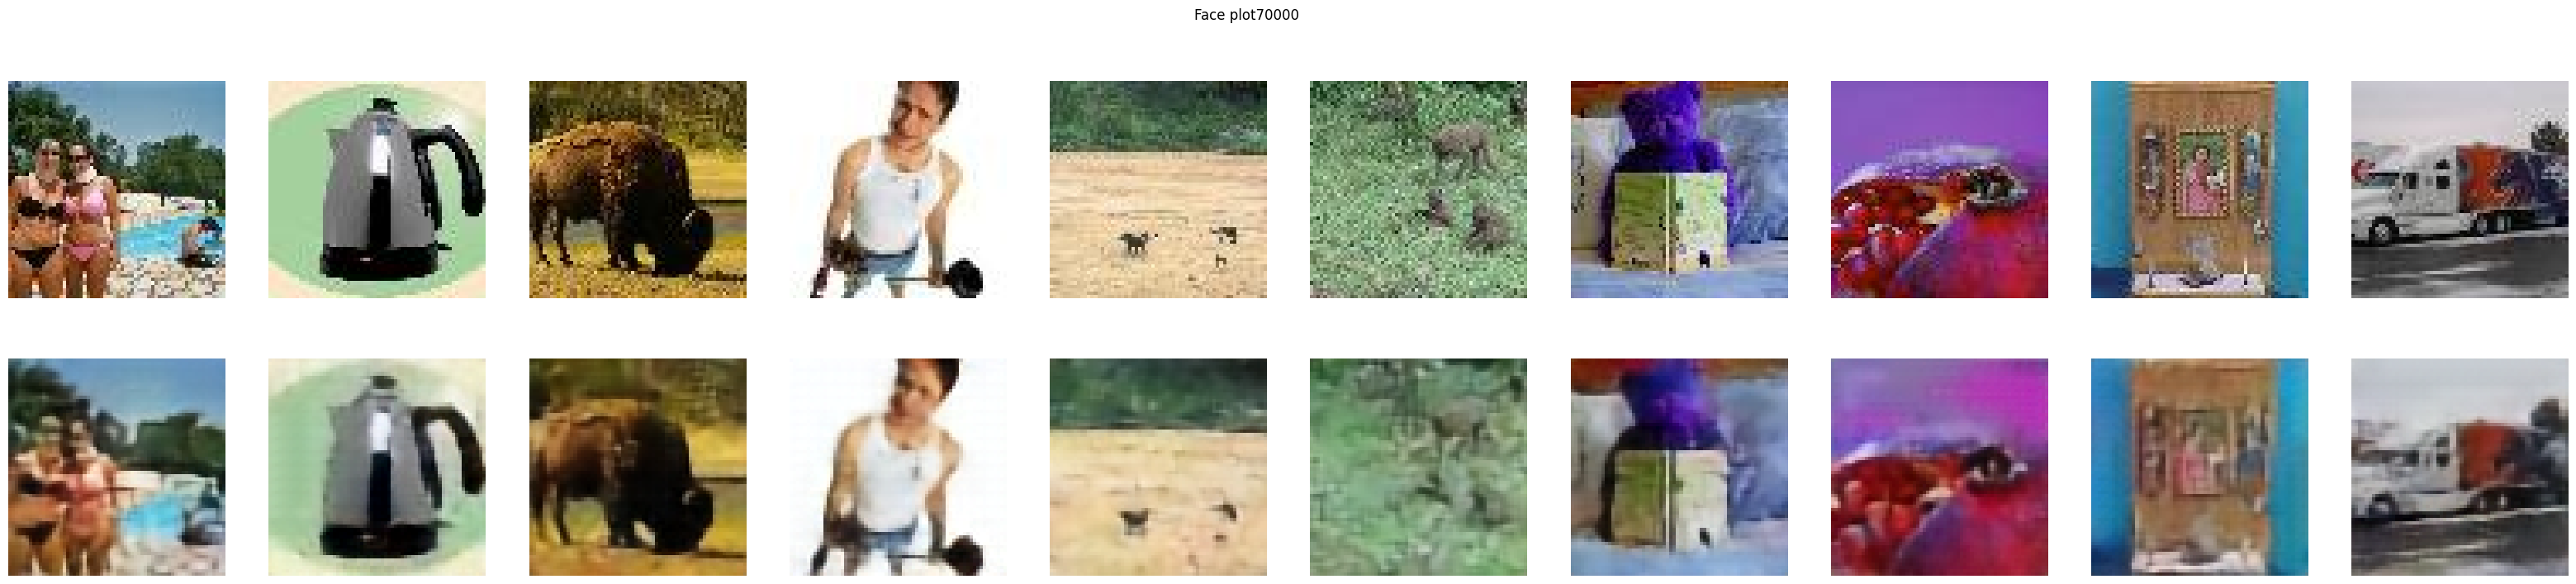

 15%|██            | 74999/500000 [11:32<1:02:16, 113.74it/s, saving=7e+4]

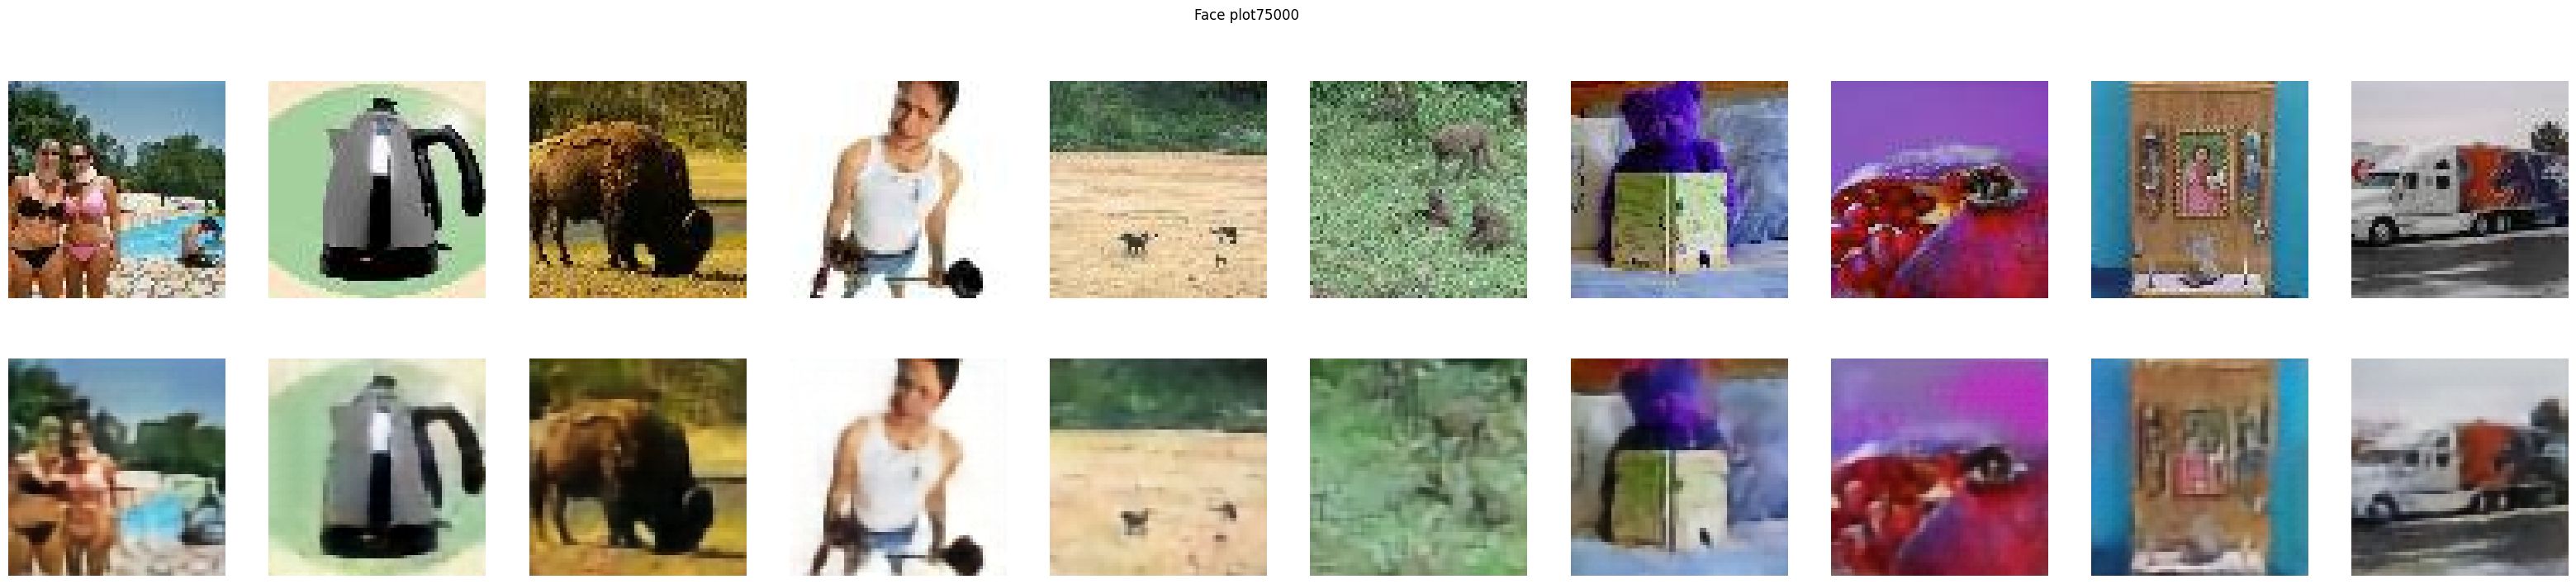

 15%|█▉           | 75588/500000 [11:37<1:05:17, 108.33it/s, saving=75000]


KeyboardInterrupt: 

In [13]:
"""
Set up optimizer and training loop
"""
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, amsgrad=True)

model.train()

from torch.utils.tensorboard import SummaryWriter

def train():
    writer = SummaryWriter()
    pbar = tqdm(range(args.n_updates), position=0)
    for i in pbar:
        (x, _) = next(iter(training_loader))
        x = x.to(device)
        optimizer.zero_grad(set_to_none=True)

        embedding_loss, x_hat, perplexity = model(x)
        recon_loss = torch.mean((x_hat - x)**2) / x_train_var
        loss = recon_loss + embedding_loss

        loss.backward()
        optimizer.step()
        results = {}

        results["recon_errors"] = recon_loss.item()
        results["perplexities"] = perplexity.item()
        results["loss_vals"] = loss.item()
        results["n_updates"] = i
        for k in results:
            writer.add_scalar(k, results[k], i)
        if i % args.log_interval == 0:
            show_image(i, 10,clip=True)
            """
            save model and print values
            """
            if args.save:
                pbar.set_postfix({"saving":i})
                hyperparameters = args.__dict__
                utils.save_model_and_results(
                    model, results, hyperparameters, args.filename)

if __name__ == "__main__":
    train()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


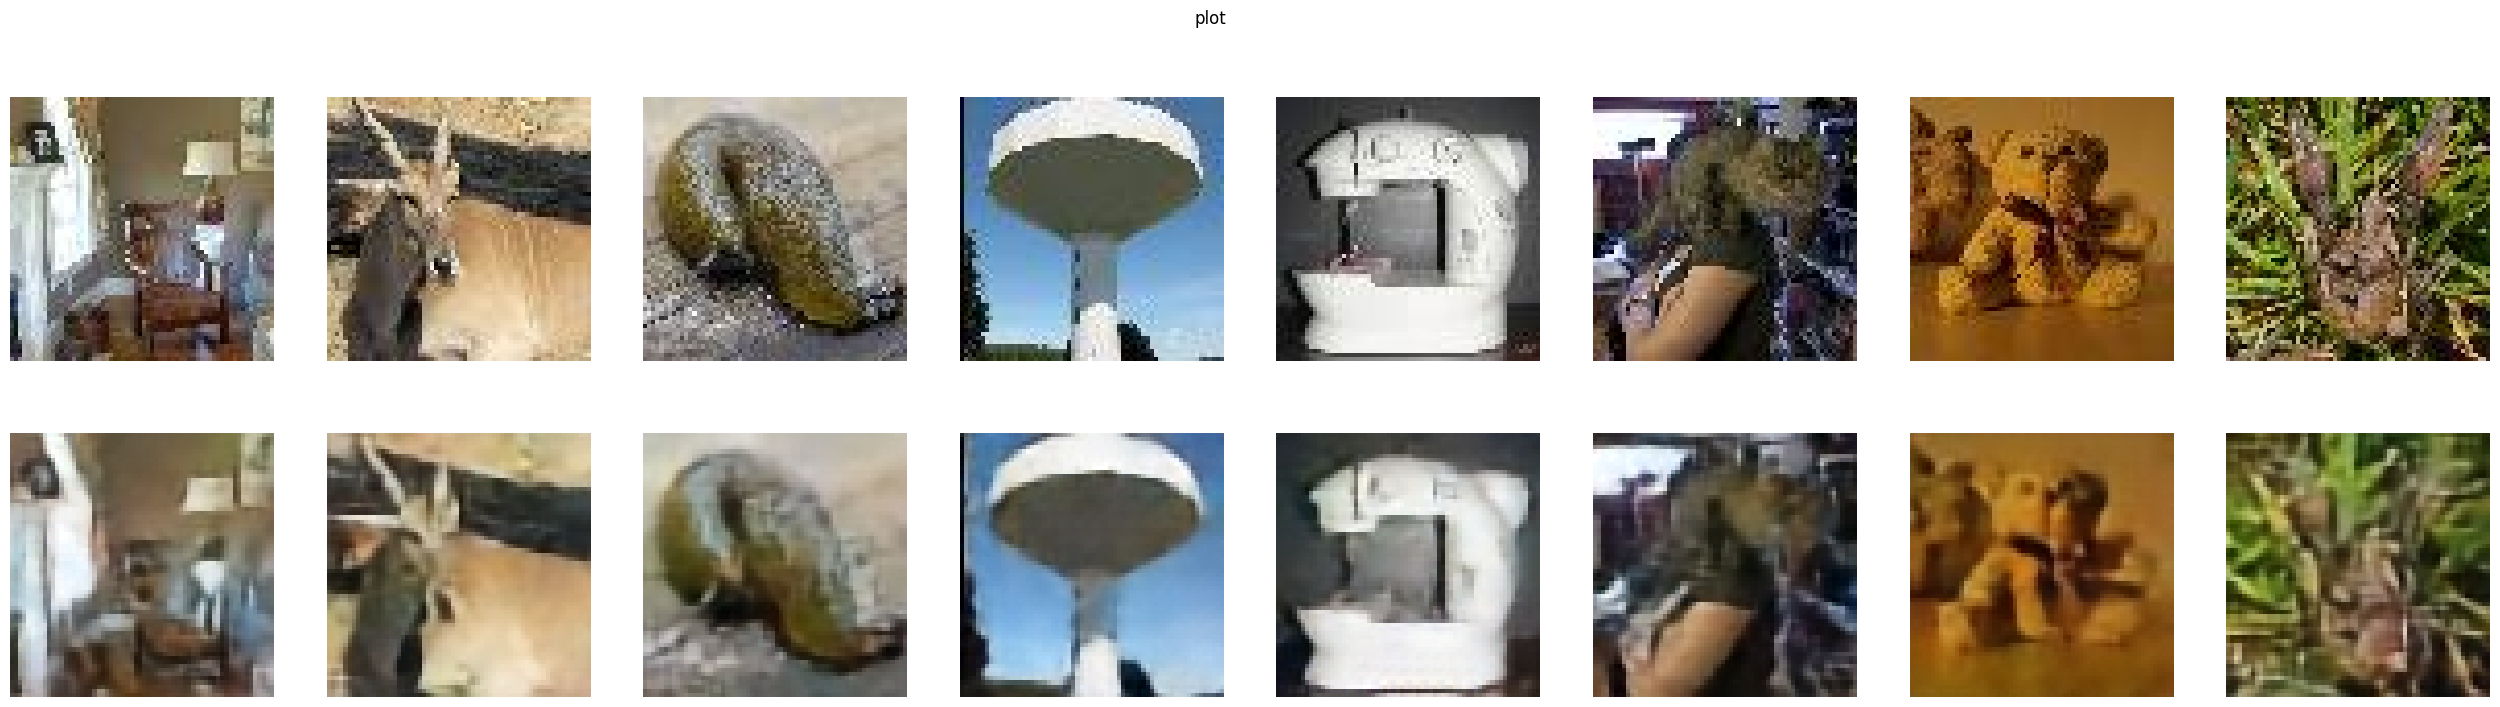

In [27]:
def show_image_random(dataset, id = 8, clip=False):
    f, axarr = plt.subplots(2, id, figsize=(id*4, 8))
    model.eval()
    scale_img = lambda x : (x+1)/2
    import random
    xxx = [random.randrange(len(dataset)) for i in range(id)]
    for i,di in enumerate(xxx):
        data = dataset[di][0]
        axarr[0][i].axis("off")
        axarr[0][i].imshow(scale_img(data.permute((1,2,0)).cpu().detach().numpy()))
        with torch.no_grad():
            _, output, _ = model(data.unsqueeze(0).to(device))
        if clip:
            output = torch.clip(output, min=-1,max=1)
        output = scale_img(output)
        output = output.squeeze(0).permute((1,2,0)).cpu().detach().numpy()
        axarr[1][i].axis("off")
        axarr[1][i].imshow(output)
    f.suptitle("plot")
    plt.show()
show_image_random(validation_data,id = 8, clip=False)